# Import data and libraries

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

tree_data = pd.read_csv('../../data/covtype.data', header=None)
tree_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_To_Hydrology',
             'Vertical_To_Hydrology', 'Horizontal_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
             'Horizontal_To_Fire'] + \
            [f'Wilderness_Area_{i}' for i in range(4)] + \
            [f'Soil_Type_{i}' for i in range(40)] + \
            ['Cover_Type']

# print(tree_data.describe())
tree_data.columns = tree_cols
print("Nan values in dataset:", tree_data.isna().sum().sum())
print(tree_data.head())

Nan values in dataset: 0
   Elevation  Aspect  Slope  Horizontal_To_Hydrology  Vertical_To_Hydrology  \
0       2596      51      3                      258                      0   
1       2590      56      2                      212                     -6   
2       2804     139      9                      268                     65   
3       2785     155     18                      242                    118   
4       2595      45      2                      153                     -1   

   Horizontal_To_Roadways  Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0                     510            221             232            148   
1                     390            220             235            151   
2                    3180            234             238            135   
3                    3090            238             238            122   
4                     391            220             234            150   

   Horizontal_To_Fire  ...  Soil_Type_31  Soil_Ty

## Split training/testing data

In [68]:
x_tree = tree_data.drop('Cover_Type', axis=1)
y_tree = tree_data['Cover_Type']

x_train, x_test, y_train, y_test = train_test_split(x_tree, y_tree, test_size=0.2)


x_underSampled, y_underSampled = RandomUnderSampler(random_state=42, sampling_strategy='majority').fit_resample(x_train, y_train)

x_underSampled = x_underSampled.to_numpy()
y_underSampled = y_underSampled.to_numpy()

cw = compute_class_weight(class_weight="balanced", classes=np.unique(y_underSampled), y=y_underSampled)

data = tree_data.to_numpy()

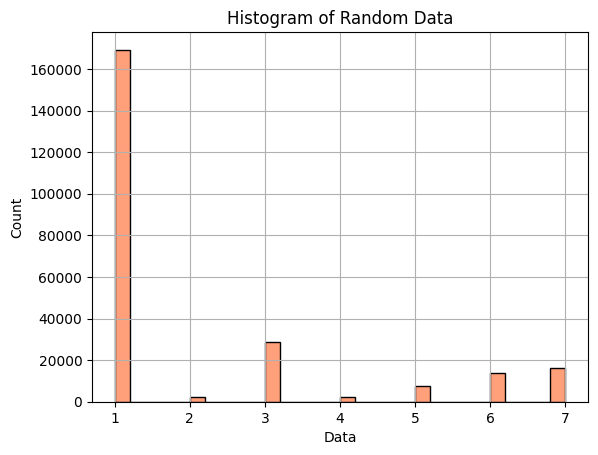

In [69]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(y_underSampled, bins=30, color='lightsalmon', edgecolor='black')
plt.xlabel('Data')
plt.ylabel('Count')
plt.title('Histogram of Random Data')
plt.grid(True)
plt.show()

## Z Scaling Dataset

In [70]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_underSampled[:, :10])

dataScaled = np.concatenate((scaled, x_underSampled[:,10:54]), axis=1)

x_zScaled_train, x_zScaled_test, y_zScaled_train, y_zScaled_test = train_test_split(dataScaled, y_underSampled.reshape(-1, 1), test_size=0.2)

## Min Max Scaled Dataset

In [71]:

scaler = MinMaxScaler()
dataScaled = scalar.fit_transform(x_underSampled[:,:54])

x_minMaxScaled_train, x_minMaxScaled_test, y_minMaxScaled_train, y_minMaxScaled_test = train_test_split(dataScaled, y_underSampled, test_size=0.2)


## L2 Scaled Dataset

In [72]:
data_scaled = np.linalg.norm(x_underSampled[:,:54])

x_l2Scaled_train, x_l2Scaled_test, y_l2Scaled_train, y_l2Scaled_test = train_test_split(dataScaled, y_underSampled, test_size=0.2)


## Mini Batch Gradient Descent with balanced class weights

In [73]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, class_weight='balanced')

clf.fit(x_zScaled_train, y_zScaled_train.ravel())

print("Z Scaled Test Accuracy: ",clf.score(x_zScaled_test, y_zScaled_test))

Z Scaled Test Accuracy:  0.6675616050616051


In [74]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, class_weight='balanced')

clf.fit(x_minMaxScaled_train, y_minMaxScaled_train.ravel())

print("Min Max Scaled Test Accuracy: ",clf.score(x_minMaxScaled_test, y_minMaxScaled_test))

Min Max Scaled Test Accuracy:  0.6722652347652348


In [75]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, class_weight='balanced')

clf.fit(x_l2Scaled_train, y_l2Scaled_train.ravel())

print("L2 Scaled Test Accuracy: ",clf.score(x_l2Scaled_test, y_l2Scaled_test))

L2 Scaled Test Accuracy:  0.6717241092241092


## Mini Batch Gradient Descent

In [76]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)

clf.fit(x_zScaled_train, y_zScaled_train.ravel())

print("Z Scaled Test Accuracy: ",clf.score(x_zScaled_test, y_zScaled_test))

Z Scaled Test Accuracy:  0.8720446220446221


In [77]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)

clf.fit(x_minMaxScaled_train, y_minMaxScaled_train.ravel())

print("Min Max Scaled Test Accuracy: ",clf.score(x_minMaxScaled_test, y_minMaxScaled_test))

Min Max Scaled Test Accuracy:  0.8722527472527473


In [78]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)

clf.fit(x_l2Scaled_train, y_l2Scaled_train.ravel())

print("L2 Scaled Test Accuracy: ",clf.score(x_l2Scaled_test, y_l2Scaled_test))

L2 Scaled Test Accuracy:  0.8716908091908092


## Stochastic Gradient Descent with balanced class weights

In [79]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(max_iter=1000, class_weight='balanced')

clf.fit(x_zScaled_train, y_zScaled_train.ravel())

print("Z Scaled Test Accuracy: ",clf.score(x_zScaled_test, y_zScaled_test))

Z Scaled Test Accuracy:  0.8217199467199467


In [80]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(max_iter=1000, class_weight='balanced')

clf.fit(x_minMaxScaled_train, y_minMaxScaled_train.ravel())

print("Min Max Scaled Test Accuracy: ",clf.score(x_minMaxScaled_test, y_minMaxScaled_test))

Min Max Scaled Test Accuracy:  0.809502997002997


In [81]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(max_iter=1000, class_weight='balanced')

clf.fit(x_l2Scaled_train, y_l2Scaled_train.ravel())

print("L2 Scaled Test Accuracy: ",clf.score(x_l2Scaled_test, y_l2Scaled_test))

L2 Scaled Test Accuracy:  0.8154761904761905


## Stochastic Gradient Descent

In [82]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(max_iter=1000)

clf.fit(x_zScaled_train, y_zScaled_train.ravel())

print("Z Scaled Test Accuracy: ",clf.score(x_zScaled_test, y_zScaled_test))

Z Scaled Test Accuracy:  0.8509199134199135


In [83]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(max_iter=1000)

clf.fit(x_minMaxScaled_train, y_minMaxScaled_train.ravel())

print("Min Max Scaled Test Accuracy: ",clf.score(x_minMaxScaled_test, y_minMaxScaled_test))

Min Max Scaled Test Accuracy:  0.847985347985348


In [84]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(max_iter=1000)

clf.fit(x_l2Scaled_train, y_l2Scaled_train.ravel())

print("L2 Scaled Test Accuracy: ",clf.score(x_l2Scaled_test, y_l2Scaled_test))

L2 Scaled Test Accuracy:  0.8492340992340992


## GridSearch

In [1]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {"penalty": ['l2', 'l1', 'elasticnet'], \
# "C": [1.0, 0.75, 0.5, 0.25, 0], \
# "solver": ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], "max_iter": [1000, 2000]}

# model_LR = LogisticRegression()

# grid_searchLR1 = GridSearchCV(model_LR, param_grid, cv=3, scoring="accuracy", verbose=10)
# grid_searchLR2 = GridSearchCV(model_LR, param_grid, cv=3, scoring="accuracy", verbose=10)
# grid_searchLR3 = GridSearchCV(model_LR, param_grid, cv=3, scoring="accuracy", verbose=10)
# grid_searchLR1.fit(x_zScaled_train, y_zScaled_train.ravel())
# grid_searchLR2.fit(x_minMaxScaled_train, y_minMaxScaled_train.ravel())
# grid_searchLR3.fit(x_l2Scaled_train, y_l2Scaled_train.ravel())

# print(grid_searchLR1.best_params_, grid_searchLR1.best_score_)
# print(grid_searchLR2.best_params_, grid_searchLR2.best_score_)
# print(grid_searchLR3.best_params_, grid_searchLR3.best_score_)